# Pre-Processing Images

## Pre-Processing Images from dataset used

In [6]:
from PIL import Image
import PIL
import os
import torch
from torch.utils.data import Dataset, DataLoader
import random
from torchvision import transforms
import numpy as np
from tqdm import tqdm
import imagehash
import shutil
import cv2
import matplotlib.pyplot as plt
import math

In [7]:
source_directory = "./data/Humans"
destination_directory = "./data/Faces_Cleaned/Base"

In [8]:
image_list = os.listdir(source_directory)
image_list[0:5]
print(len(image_list))

7220


In [172]:
def crop_images_face(source_directory, destination_directory, image_names):
    # Load the pre-trained Haar Cascade classifier for face detection
        non_included_images = []
        os.makedirs(destination_directory, exist_ok=True)
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        i = 0
        for image_name in tqdm(image_names, desc = "Cropping all possible images and deleting images that cannot be easily cropped"):
        # Read the image
            
            read_path = os.path.join(source_directory, image_name)
            image = cv2.imread(read_path)
            cropped_image = None;
            
            
            
            
            # Convert to grayscale for better face detection
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Detect faces in the image
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6, minSize=(224, 224))
            #print(len(faces))
            # Draw rectangle around the faces
            if(len(faces) == 1):   
                
                x = faces[0][0]
                y = faces[0][1]
                w = faces[0][2]
                h = faces[0][3]
                if(w > 224 and h > 224):
                    #print("Resizing required")
                    if (w <= h):
                        division_value = w
                    else:
                        division_value = h
                    scale_factor = 1 / (math.ceil(division_value / 224))
                    #print(scale_factor)
                    #print(image.shape)
                    new_width = int(image.shape[1] * scale_factor)
                    new_height = int(image.shape[0] * scale_factor)
                    #print(new_width, new_height)
                    image = cv2.resize(image, (new_width, new_height))
                    x1 = int(x * scale_factor) 
                    x2 = int((x + w) * scale_factor)
                    y1 = int(y * scale_factor)
                    y2 = int((y + h) * scale_factor)
                    x1_add = 0
                    x2_add = 0
                    y1_add = 0
                    y2_add = 0
                    #print("Original cutout: ", x1, y1, x2, y2)
                    #cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    if(image.shape[0] >= 224 and image.shape[1] >= 224):
                        if((x2 - x1) < 224):
                            #print("width:", x2-x1)
                            if((x2-x1)%2 == 0):
                                expected_width_addition = (224 - (x2-x1)) / 2
                                bonus_x_add = 0
                            else:
                                expected_width_addition = math.floor((224 - (x2-x1)) / 2)
                                bonus_x_add = 1
                            
                            if((x1 - expected_width_addition) < 0):
                                
                                x1_add = x1
                                x2_add = expected_width_addition + (expected_width_addition - x1) + bonus_x_add
            
                            elif((x2 + expected_width_addition) > image.shape[1]):
                                x1_add = expected_width_addition + (expected_width_addition - (image.shape[1] - x2)) + bonus_x_add
                                x2_add = image.shape[1] - x2
                            
                            else: 
                                #print("normx")
                                x1_add = expected_width_addition
                                x2_add = expected_width_addition
                                if((x1 - x1_add) == 0):
                                    x1_add = expected_width_addition
                                    x2_add = expected_width_addition + bonus_x_add
                                else:
                                    x1_add = expected_width_addition + bonus_x_add
                                    x2_add = expected_width_addition
                    
                        if((y2 - y1) < 224):
                            #print("height:", y2-y1)
                            if((y2-y1)%2 == 0):
                                expected_height_addition = (224 - (y2-y1)) / 2
                                bonus_y_add = 0
                            else:
                                expected_height_addition = math.floor((224 - (y2-y1)) / 2)
                                bonus_y_add = 1
                            if((y1 - expected_height_addition) < 0):
                                y1_add = y1
                                y2_add = expected_height_addition + (expected_height_addition - y1) + bonus_y_add
            
                            elif((y2 + expected_height_addition) > image.shape[0]):
                                y1_add = expected_height_addition + (expected_height_addition - (image.shape[0] - y2)) + bonus_y_add
                                y2_add = image.shape[0] - y2
                            
                            else: 
                                #print("normy")
                                y1_add = expected_height_addition
                                y2_add = expected_height_addition
                                if((y1 - y1_add) == 0):
                                    y1_add = expected_height_addition
                                    y2_add = expected_height_addition + bonus_y_add
                                else:
                                    y1_add = expected_height_addition + bonus_y_add
                                    y2_add = expected_height_addition
                        cropped_x1 = int(x1 - x1_add)
                        cropped_x2 = int(x2 + x2_add)
                        cropped_y1 = int(y1 - y1_add)
                        cropped_y2 = int(y2 + y2_add)
                        #print("Top Left Corner (", cropped_x1, ",", cropped_y1, ") Bottom Right Corner (", cropped_x2, ",", cropped_y2, ")")
                        cropped_image = image[cropped_y1:cropped_y2, cropped_x1:cropped_x2]
                        i += 1
                        save_name = "image_" + str(i) + ".jpg"
                        save_path = os.path.join(destination_directory, save_name)
                        cv2.imwrite(save_path, cropped_image)
                    else:
                        non_included_images.append(image_name)
                        
                        
                else:
                    cropped_image = image[y:y+h, x:x+w]
                    i += 1
                    save_name = "image_" + str(i) + ".jpg"
                    save_path = os.path.join(destination_directory, save_name)
                    cv2.imwrite(save_path, cropped_image)
            else:
                
                non_included_images.append(image_name)
    
    
        print(len(image_names) - len(non_included_images),"images successfuly processed")
        print(len(non_included_images),"images not included due to cropping issues")
        
            
        
        
            
            
            
            
        
    

In [173]:
def get_image_hash(image_path):
    try:
        img = Image.open(image_path)
        if img.mode == 'P':
            img = img.convert('RGBA')
        img = img.resize((256, 256))  # Resize to make hashing faster
        return imagehash.average_hash(img)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
"""
def copy_file_name_list(source_directory, destination_directory, file_name_list):

    os.makedirs(destination_directory, exist_ok=True)
    
    for file_name in tqdm(file_name_list, desc = "Copying files to new directory"):
        source_path = os.path.join(source_directory, file_name)
        if os.path.isfile(source_path):  # Check if the file exists
            destination_path = os.path.join(destination_directory, file_name)
            shutil.copy(source_path, destination_path)  # Copy the file
            #print("Copied", file_name, "to", destination_directory)
        else:
            print(file_name, "not found in source directory", source_directory)
            raise RunTimeError()
"""

"""
def are_images_identical(image_path1, image_path2):
    try:
        img1 = Image.open(image_path1)
        img2 = Image.open(image_path2)
        
        if img1.size != img2.size or img1.mode != img2.mode:
            return False

        

        return np.array_equal(array1, array2)
    
    except FileNotFoundError:
        print("Error: One or both image files not found.")
        return False
    except Exception as e:
         print(f"An error occurred: {e}")
         return False
"""
def non_duplicate_cropped_dir(source_directory, destination_directory):
    directory_list = os.listdir(source_directory)
    image_files = [f for f in directory_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    num_images = len(image_files)
    unique_image_names = []
    unique_hashes = []
    for i in tqdm(range(num_images), desc = "Deleting Duplicate Images") :
        try:
            image_path = os.path.join(source_directory, image_files[i])
            image_hash = get_image_hash(image_path)
            if image_hash not in unique_hashes:
                unique_image_names.append(image_files[i])
                unique_hashes.append(image_hash)
                
            
            """for j in range(i + 1, num_images):
                image_path1 = os.path.join(directory, image_files[i])
                image_path2 = os.path.join(directory, image_files[j])
                
                if are_images_identical(image_path1, image_path2):
                    
                    if(image_path2 not in duplicate_image_paths):
                        duplicate_image_paths.append(image_path2)
            """
        except Exception as e:
            print("Image", image_files[i], "returned the following warning/error:")
            print(e)
    
    crop_images_face(source_directory, destination_directory, unique_image_names)
    #copy_file_name_list(source_directory, destination_directory, unique_image_names)




                    
                    
                    
    

In [174]:
non_duplicate_cropped_dir("./data/Humans", "./data/Faces_Cleaned/Base")

Deleting Duplicate Images: 100%|██████████| 7219/7219 [04:05<00:00, 29.37it/s]
Cropping all possible images and deleting images that cannot be easily cropped: 100%|██████████| 3276/3276 [01:26<00:00, 37.93it/s]

2215 images successfuly processed
1061 images not included due to cropping issues


In [3]:

def create_square_mask(image_size, occlusion_percentage):
    width, height = image_size
    mask_area = int(width * height * occlusion_percentage)
    side_length = int(np.sqrt(mask_area))
    side_length = min(side_length, width, height)
    
    start_x = (width - side_length) // 2
    start_y = (height - side_length) // 2
    
    mask = np.zeros((height, width), dtype=np.uint8)
    mask[start_y:start_y + side_length, start_x:start_x + side_length] = 1
    
    return mask

# Function to create multiple small square masks
def create_multiple_square_masks(image_size, occlusion_percentage):
    width, height = image_size
    mask_area = int(width * height * occlusion_percentage)
    
    mask = np.zeros((height, width), dtype=np.uint8)
    
    area_covered = 0
    while area_covered < mask_area:
        side_length = random.randint(5, 20)
        x = random.randint(0, width - side_length)
        y = random.randint(0, height - side_length)
        
        mask[y:y + side_length, x:x + side_length] = 1
        area_covered += side_length * side_length
    
    return mask
'''
# Function to create an irregular VOC2012-like mask
def create_irregular_mask(image_size, occlusion_percentage):
    width, height = image_size
    mask_area = int(width * height * occlusion_percentage)
    
    mask = np.ones((height, width), dtype=np.uint8)
    
    while mask_area > 0:
        shape_type = random.choice(["rectangle", "ellipse"])
        if shape_type == "rectangle":
            rect_width = random.randint(20, 50)
            rect_height = random.randint(20, 50)
            x = random.randint(0, width - rect_width)
            y = random.randint(0, height - rect_height)
            mask[y:y+rect_height, x:x+rect_width] = 0
            mask_area -= rect_width * rect_height
        else:
            rect_width = random.randint(20, 50)
            rect_height = random.randint(20, 50)
            x = random.randint(0, width - rect_width)
            y = random.randint(0, height - rect_height)
            rr, cc = np.ellipse(x + rect_width//2, y + rect_height//2, rect_width//2, rect_height//2, shape=mask.shape)
            mask[rr, cc] = 0
            mask_area -= rect_width * rect_height
    
    return mask
'''


# Custom Dataset Class for Inpainting (Return 9 Variations per Image)
class CustomInpaintingDataset(Dataset):
    def __init__(self, image_paths, occlusion_percentages=[0.10, 0.25, 0.50], transform=None):
        """
        :param image_paths: List of paths to images
        :param occlusion_percentages: List of occlusion percentages (e.g., 0.10, 0.25, 0.50)
        :param transform: Optional transform for the image
        """
        self.image_paths = image_paths
        self.occlusion_percentages = occlusion_percentages
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths) * len(self.occlusion_percentages) * 2  # 3 mask types
    
    def __getitem__(self, idx):
        
        img_idx = idx // (len(self.occlusion_percentages) * 2)
        mask_idx = idx % (len(self.occlusion_percentages) * 2)
        
        
        image = Image.open(self.image_paths[img_idx]).convert("RGB")
        width, height = image.size
        if self.transform:
            image = self.transform(image)
        else:
            
            to_tensor = transforms.ToTensor()
            image = to_tensor(image)

        to_pil = transforms.ToPILImage()

        # Make sure the tensor is in the correct shape (C, H, W)
        image= to_pil(image) 
        
        occlusion_percentage = self.occlusion_percentages[mask_idx % len(self.occlusion_percentages)]
        
        if mask_idx < 2:
            mask = create_square_mask((width, height), occlusion_percentage)  # Center square mask
        else:
            mask = create_multiple_square_masks((width, height), occlusion_percentage)  # Multiple small squares
        #else:
            #mask = create_irregular_mask((width, height), occlusion_percentage)  # Irregular mask
        
        
        masked_image = np.array(image)
        masked_image[mask == 1] = 0
        
        
        masked_image = Image.fromarray(masked_image)

        
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        masked_image = to_tensor(masked_image)
        """
        if self.transform:
            image = self.transform(image)
            masked_image = self.transform(masked_image)
        else:
            
            to_tensor = transforms.ToTensor()
            image = to_tensor(image)
            masked_image = to_tensor(masked_image)
        """
        
        return masked_image, image, torch.tensor(mask, dtype=torch.float32)






In [4]:
image_paths = [os.path.join(destination_directory, image_name) for image_name in os.listdir(destination_directory)]


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip()
    
])
#transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),

dataset = CustomInpaintingDataset(image_paths, occlusion_percentages=[0.10, 0.25, 0.50], transform = transform)


dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

831
Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


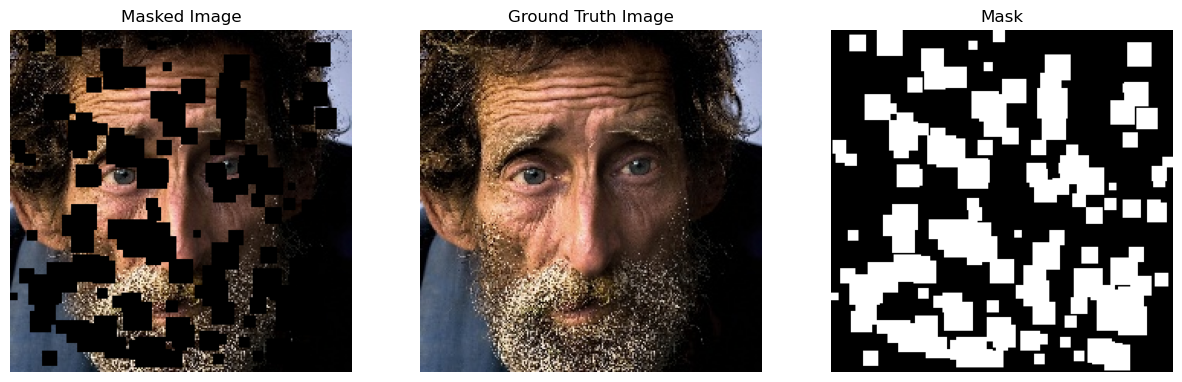

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


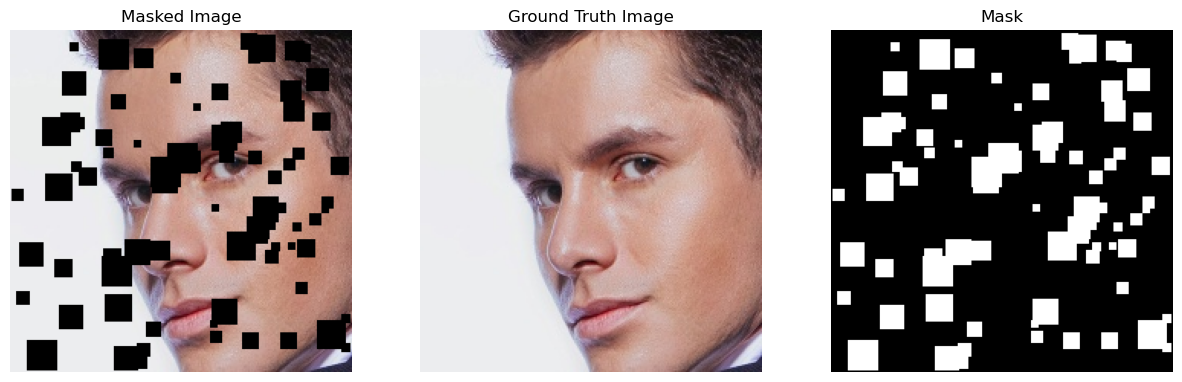

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


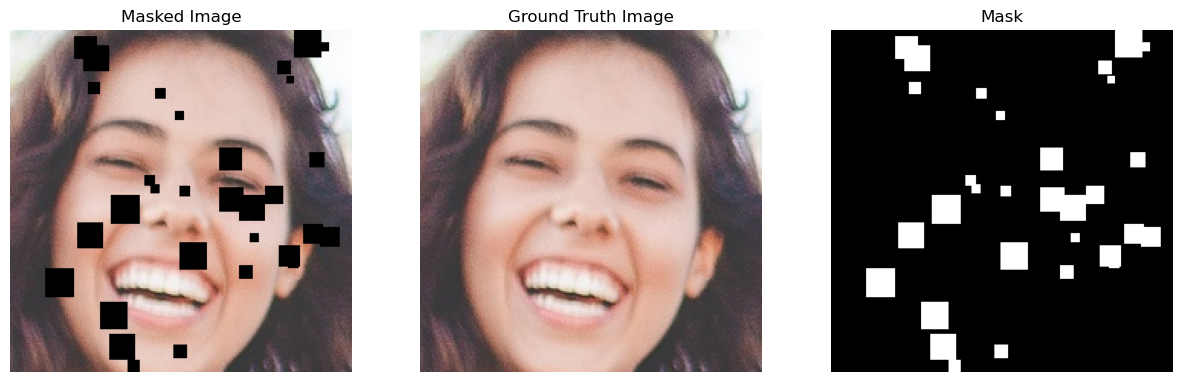

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


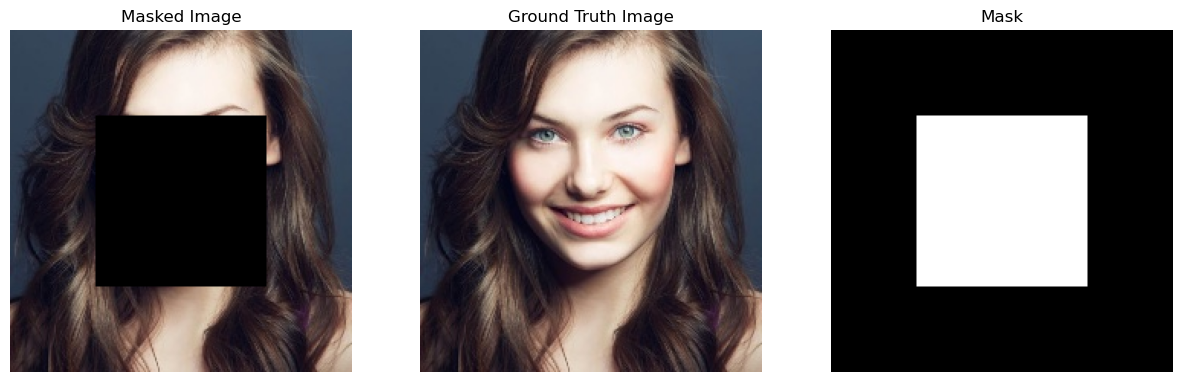

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


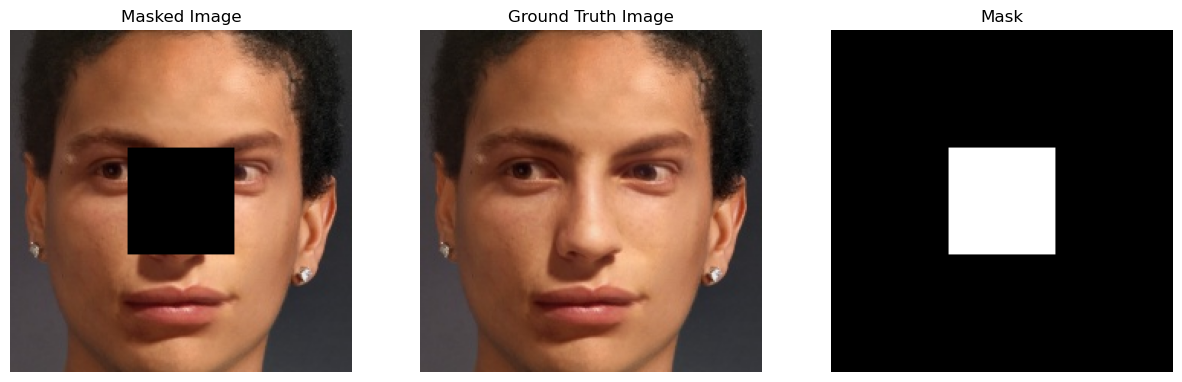

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


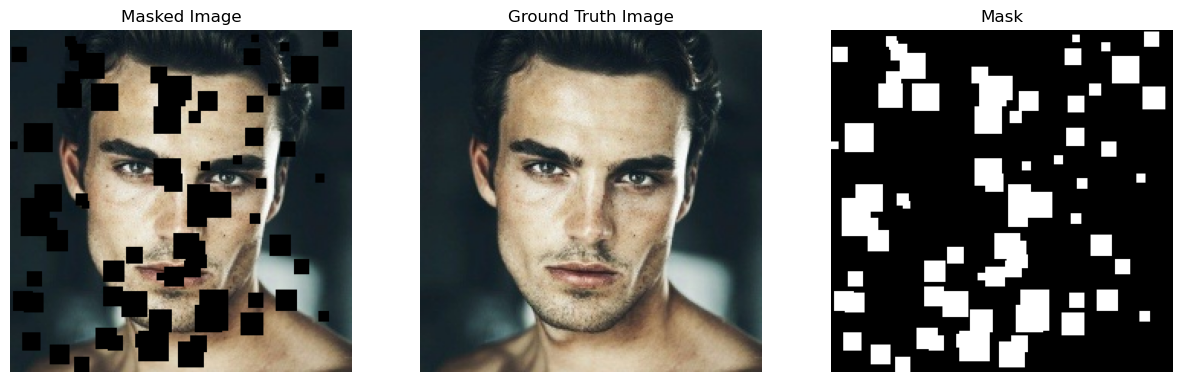

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


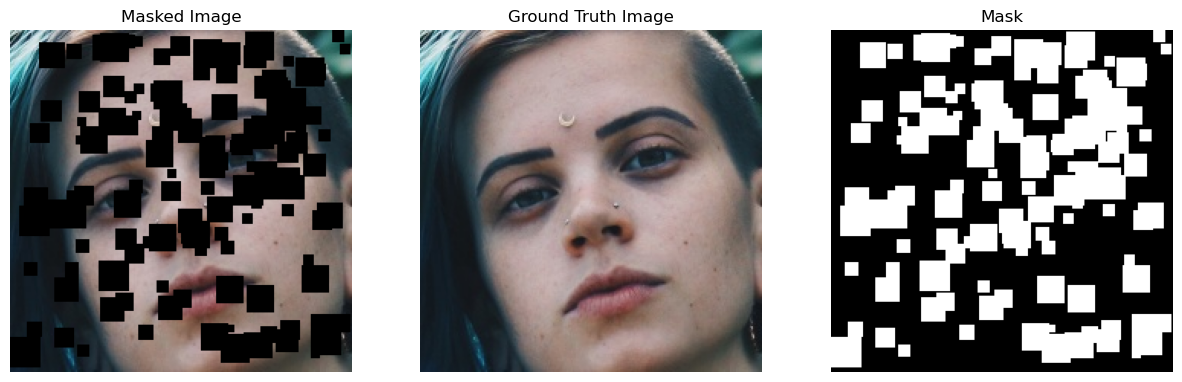

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


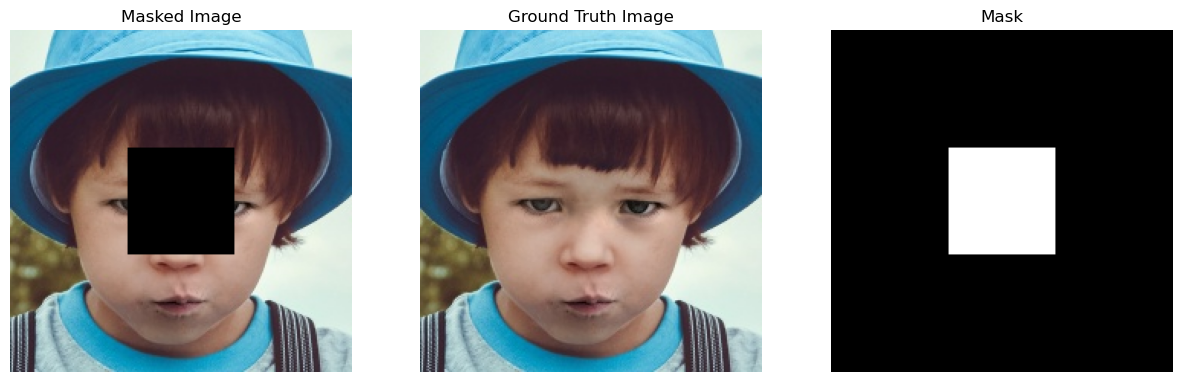

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


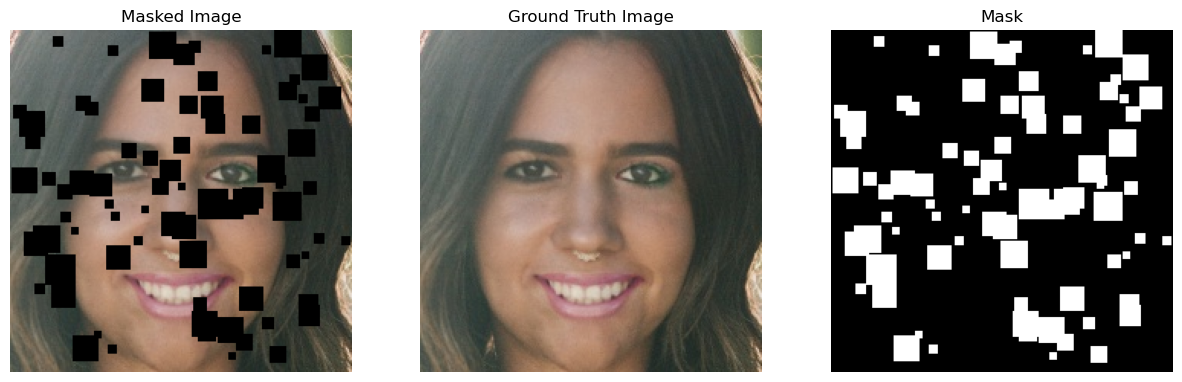

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


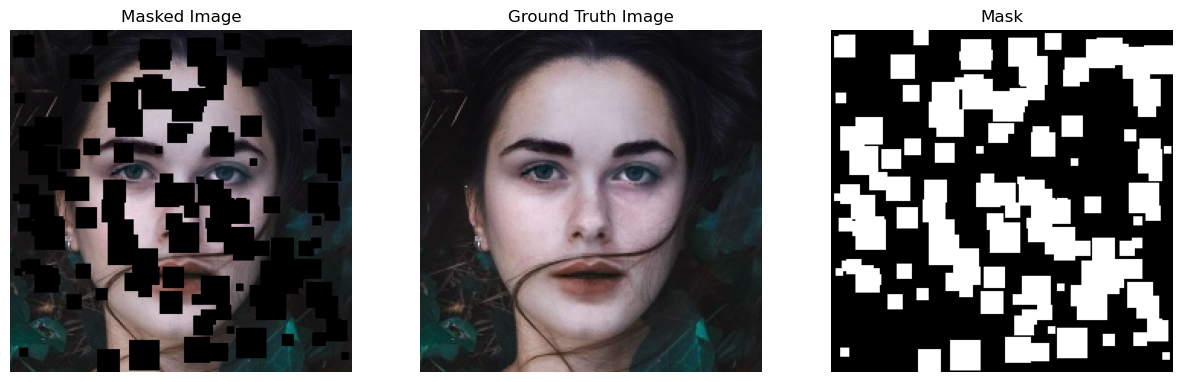

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


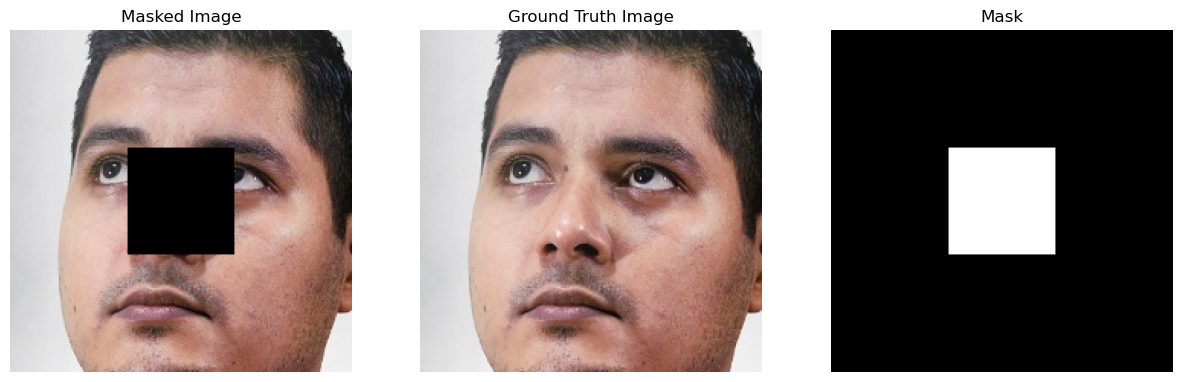

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


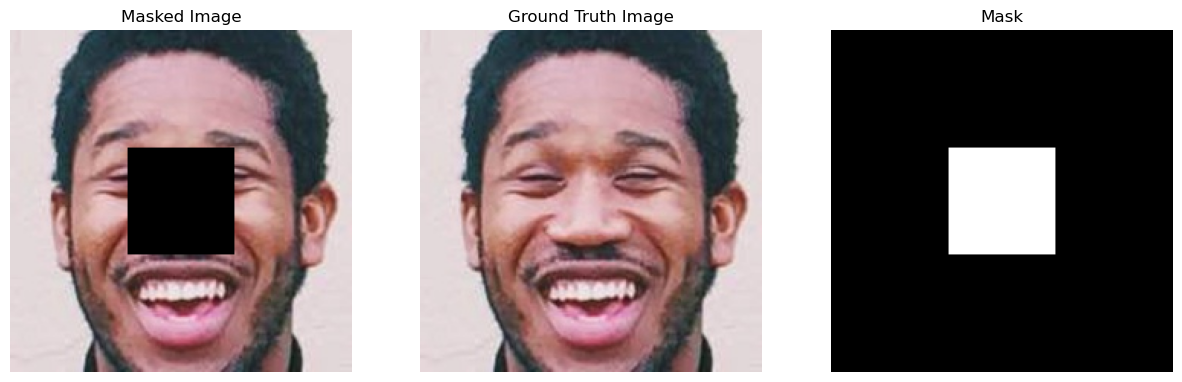

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


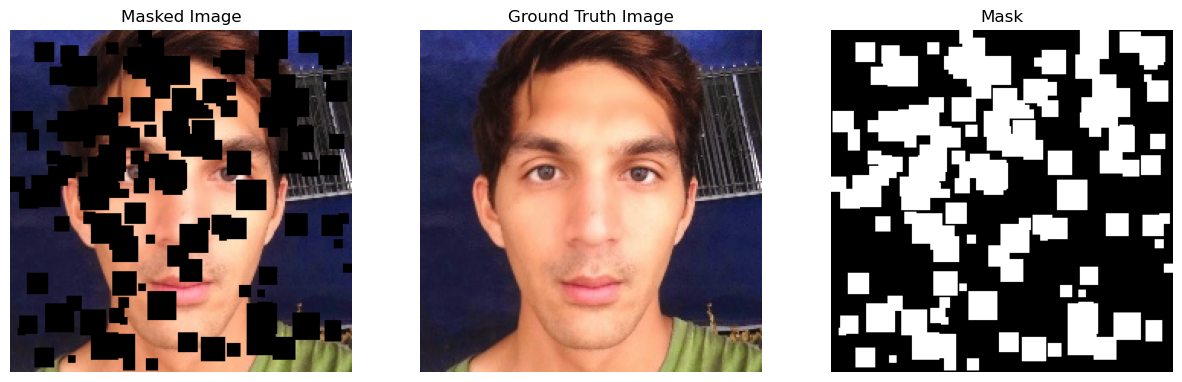

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


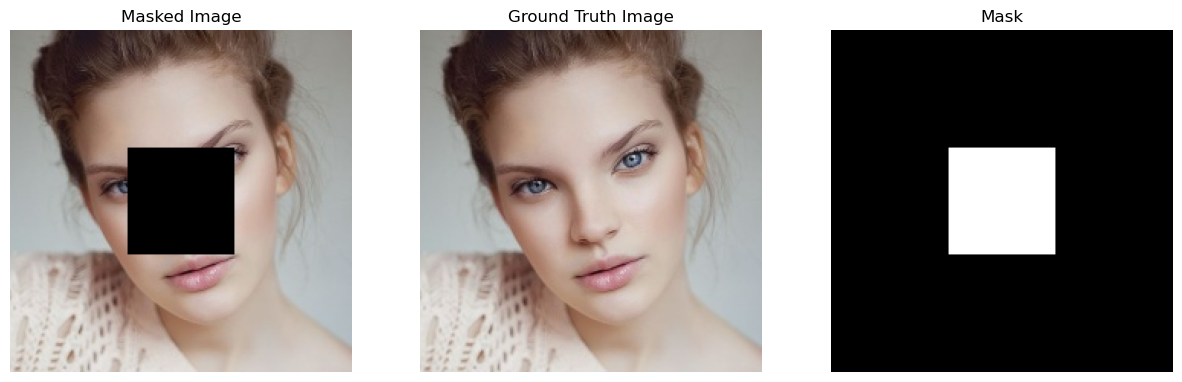

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


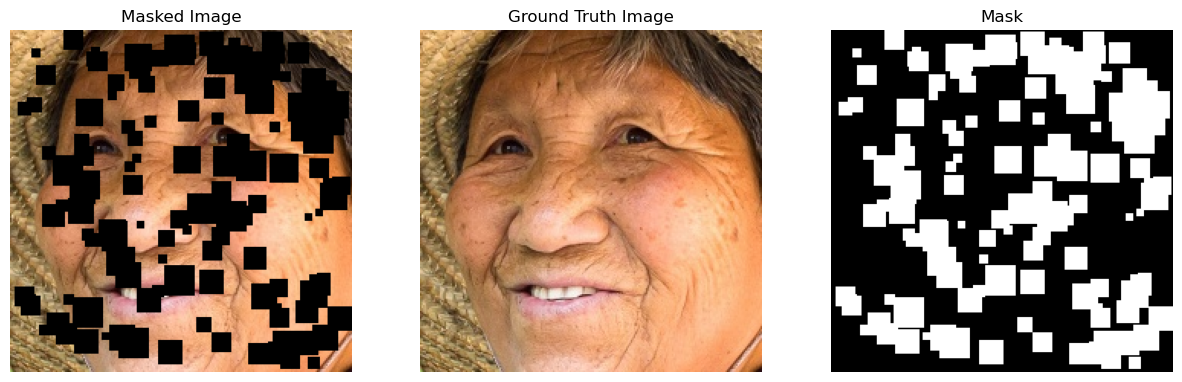

Masked Image shape: torch.Size([16, 3, 224, 224]), Ground Truth shape: torch.Size([16, 3, 224, 224]), Mask shape: torch.Size([16, 224, 224])


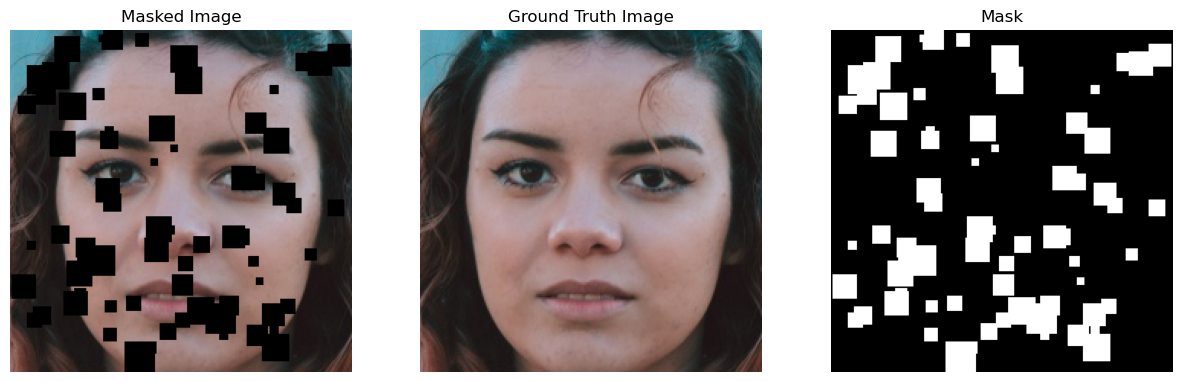

In [5]:

def tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0).numpy()
    # Clip values to the valid range for images (0-255)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    return image

"""
def reverse_normalization(tensor, mean, std):
    
    Reverse the normalization by multiplying by std and adding mean.
    Args:
        tensor: Tensor of shape (C, H, W)
        mean: Mean for each channel (C,)
        std: Std for each channel (C,)
    Returns:
        tensor: Denormalized tensor
    
    mean = torch.tensor(mean).view(3, 1, 1)  # Make mean shape (C, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)    # Make std shape (C, 1, 1)
    
    # Reverse the normalization
    tensor = tensor * std + mean
    return tensor
"""

"""
def tensor_to_image(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    
    #Converts a tensor to a NumPy image after reversing normalization.
    
    
    # Reverse normalization
    tensor = reverse_normalization(tensor, mean, std)
    
    # Ensure the values are in the valid range [0, 1] before converting
    tensor = tensor.clamp(0, 1)  # Clamping the tensor values in the [0, 1] range
    
    # Convert from Tensor (C, H, W) to (H, W, C) and then to a NumPy array
    image = tensor.permute(1, 2, 0).numpy()
    
    # Convert values to the range [0, 255]
    image = np.clip(image, 0, 1)  # Ensure the values are within [0, 1]
    image = (image * 255).astype(np.uint8)  # Convert to 8-bit per channel
    
    return image
"""
print(len(dataloader))
for masked_images, ground_truth_images, masks in dataloader:
    for i in range(masked_images.shape[0]):
        print(f"Masked Image shape: {masked_images.shape}, Ground Truth shape: {ground_truth_images.shape}, Mask shape: {masks.shape}")
        masked_image = tensor_to_image(masked_images[i])
        ground_truth_image = tensor_to_image(ground_truth_images[i])
        mask = masks[i].numpy()  # Mask is in shape (H, W), no need to permute
        
        # Plot the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
        # Display masked image
        axes[0].imshow(masked_image)
        axes[0].set_title("Masked Image")
        axes[0].axis('off')
    
        # Display ground truth image
        axes[1].imshow(ground_truth_image)
        axes[1].set_title("Ground Truth Image")
        axes[1].axis('off')
    
        # Display mask (mask is a binary image, so display it as grayscale)
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title("Mask")
        axes[2].axis('off')
    
        plt.show()
    #Only 1 batch
    break;
    